## new library
- sympy : symbolic math calculation

## things to ponder
- how normalization impact the weight optimization process
- why the average of those errors should tend towards zero once there are enough trees in random forest

# Titanic Data

In [36]:
import pandas as pd
import numpy as np 
import os
import torch 
from torch import tensor

In [48]:
df = pd.read_csv("train.csv")

In [49]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [51]:
# it return multiple values when there is tie
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [52]:
df.fillna(modes,inplace=True)

In [53]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [54]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

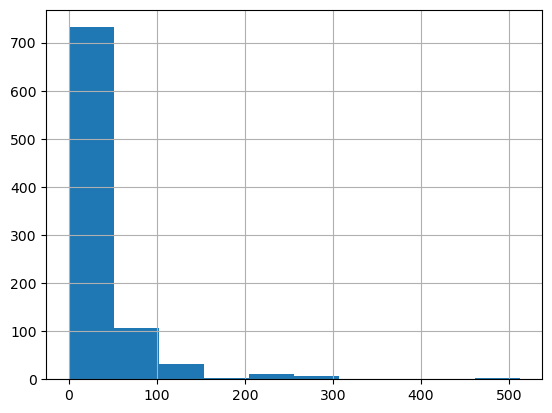

In [55]:
df.Fare.hist()

In [56]:
df['logfare'] = np.log(df.Fare+1)

<Axes: >

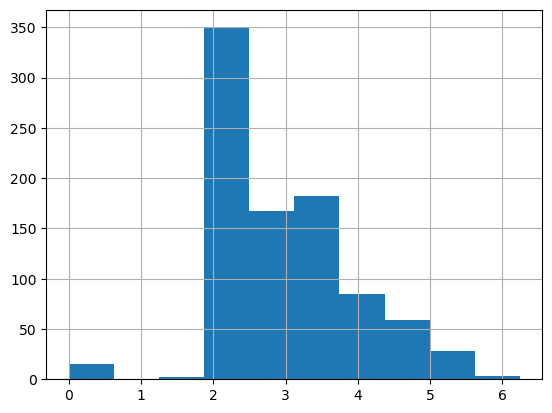

In [57]:
df.logfare.hist()

In [58]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [59]:
df.describe(include=object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [60]:
df = pd.get_dummies(df,columns=['Sex','Pclass','Embarked'],dtype=int)

In [61]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'logfare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [62]:
added_columns = ['Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [63]:
df[added_columns].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


In [64]:
t_dep = tensor(df.Survived)

In [65]:
indep_cols = ['Age', 'SibSp', 'Parch', 'logfare'] + added_columns

In [66]:
t_indep = tensor(df[indep_cols].values,dtype=torch.float)

In [67]:
t_indep.shape

torch.Size([891, 12])

In [69]:
val,index = t_indep.max(dim=0)
t_indep = t_indep/val

In [72]:
torch.manual_seed(442)
weights = torch.rand(t_indep.shape[1])-0.5
weights

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625])

In [73]:
preds = (t_indep*weights).sum(axis=1)

In [75]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,
         0.2128, -0.5770])

In [76]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5200)

In [77]:
def cal_pred(weights,t_indep): return (t_indep*weights).sum(axis=1)
def cal_loss(weights,t_indep,t_dep) : return torch.abs(cal_pred(weights,t_indep)-t_dep).mean()

In [78]:
weights.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [79]:
loss = cal_loss(weights,t_indep,t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [82]:
loss.backward()

In [83]:
weights.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,
         0.0797, -0.1886, -0.0617,  0.1639])

In [84]:
with torch.no_grad():
    weights.sub_(weights.grad*0.1)
    print(cal_loss(weights,t_indep,t_dep))

tensor(0.5056)


In [85]:
from fastai.data.transforms import RandomSplitter
trn_split, valid_split  = RandomSplitter(seed=42)(df)

In [87]:
trn_indep, val_indep = t_indep[trn_split], t_indep[valid_split]
trn_dep, val_dep = t_dep[trn_split],t_dep[valid_split]

In [89]:
def update_coeff(weights,lr): return weights.sub_(weights.grad*0.1)

In [93]:
def one_epoch(weights,lr):
    loss = cal_loss(weights,trn_indep,trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeff(weights,lr)
    print(f"loss:{loss:.3f};")

In [98]:
def init_coeff(n_coeff) : return (torch.rand(n_coeff)-0.5).requires_grad_()

In [99]:
def train_model(n_coeff, epoch=30, lr=0.1):
    torch.manual_seed(442)
    weights = init_coeff(n_coeff)
    for i in range(epoch):  one_epoch(weights,lr)
    return weights

In [101]:
weights = train_model(t_indep.shape[1],10,0.1)

loss:0.518;
loss:0.504;
loss:0.480;
loss:0.449;
loss:0.399;
loss:0.351;
loss:0.307;
loss:0.293;
loss:0.315;
loss:0.363;


In [102]:
def show_coeff() : return dict(zip(indep_cols,weights.requires_grad_(False)))

In [103]:
show_coeff()

{'Age': tensor(-0.1332),
 'SibSp': tensor(0.0675),
 'Parch': tensor(0.2445),
 'logfare': tensor(0.2081),
 'Sex_female': tensor(0.5610),
 'Sex_male': tensor(-0.4620),
 'Pclass_1': tensor(0.9443),
 'Pclass_2': tensor(0.4502),
 'Pclass_3': tensor(0.3636),
 'Embarked_C': tensor(0.4254),
 'Embarked_Q': tensor(0.3508),
 'Embarked_S': tensor(0.0345)}

In [106]:
preds = cal_pred(weights,val_indep)
results = val_dep.bool()==(preds>0.5)
results[:10]

tensor([True, True, True, True, True, True, True, True, True, True])

In [107]:
def cal_acc(weights) : return ( val_dep.bool()==(cal_pred(weights,val_indep)>0.5)).float().mean()

In [108]:
cal_acc(weights) 

tensor(0.7640)

In [109]:
preds[:20]

tensor([ 1.4085,  0.2848,  0.3573,  0.1364,  0.0690,  0.0776,  1.4731,  1.0870,
         0.1872,  1.4643, -0.0442,  0.4292,  0.0619,  1.3083, -0.0534,  0.5524,
         0.5191,  1.1547,  0.0676,  0.9832])

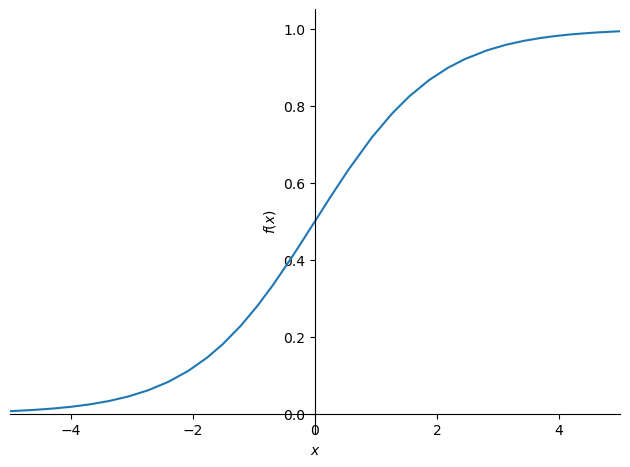

In [110]:
import sympy
sympy.plot("1/(1+exp(-x))",xlim=(-5,5))

In [128]:
def cal_pred(weights,t_indep): return torch.sigmoid((t_indep*weights).sum(axis=1))

In [129]:
weights = train_model(len(indep_cols),20,0.1)

loss:0.503;
loss:0.501;
loss:0.497;
loss:0.490;
loss:0.482;
loss:0.471;
loss:0.459;
loss:0.445;
loss:0.430;
loss:0.415;
loss:0.399;
loss:0.384;
loss:0.370;
loss:0.358;
loss:0.346;
loss:0.336;
loss:0.328;
loss:0.321;
loss:0.314;
loss:0.309;


In [130]:
cal_acc(weights)

tensor(0.7079)

In [131]:
show_coeff()

{'Age': tensor(-0.8473),
 'SibSp': tensor(0.0566),
 'Parch': tensor(0.2316),
 'logfare': tensor(-0.4314),
 'Sex_female': tensor(0.5792),
 'Sex_male': tensor(-2.0885),
 'Pclass_1': tensor(0.7963),
 'Pclass_2': tensor(0.2891),
 'Pclass_3': tensor(-0.9358),
 'Embarked_C': tensor(-0.3155),
 'Embarked_Q': tensor(0.1339),
 'Embarked_S': tensor(-0.6161)}

In [138]:
tst_df = pd.read_csv("test.csv")
tst_df.Fare = tst_df.Fare.fillna(0)
tst_df.fillna(modes,inplace=True)
tst_df['logfare'] = np.log(tst_df.Fare+1)
tst_df = pd.get_dummies(tst_df, columns=['Sex','Pclass','Embarked'],dtype=int)

tst_tens = tensor(tst_df[indep_cols].values,dtype=torch.float)
tst_tens = tst_tens/val

In [142]:
tst_df['Survived'] = (cal_pred(weights,tst_tens)>0.5).int()

In [145]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('submission.csv')

In [146]:
def cal_pred(weights,t_indep) : return torch.sigmoid(t_indep@weights)

In [147]:
def init_coeff(n_coeff): return (torch.rand(n_coeff,1)*0.1).requires_grad_()

In [148]:
init_coeff(len(indep_cols))

tensor([[0.0672],
        [0.0732],
        [0.0142],
        [0.0499],
        [0.0317],
        [0.0259],
        [0.0549],
        [0.0587],
        [0.0447],
        [0.0813],
        [0.0351],
        [0.0245]], requires_grad=True)

In [149]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [152]:
weights = train_model(len(indep_cols),lr=2)

loss:0.512;
loss:0.510;
loss:0.505;
loss:0.499;
loss:0.490;
loss:0.479;
loss:0.467;
loss:0.452;
loss:0.436;
loss:0.419;
loss:0.402;
loss:0.385;
loss:0.369;
loss:0.355;
loss:0.342;
loss:0.331;
loss:0.322;
loss:0.314;
loss:0.308;
loss:0.302;
loss:0.297;
loss:0.292;
loss:0.288;
loss:0.284;
loss:0.280;
loss:0.276;
loss:0.272;
loss:0.268;
loss:0.264;
loss:0.260;


In [153]:
cal_acc(weights)

tensor(0.7921)

In [190]:
def init_coeff(n_coeff,n_hidden=20):
    layer1 = (torch.rand(n_coeff,n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden,1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [191]:
import torch.nn.functional as F

In [192]:
def cal_pred(weights,indpen):
    l1,l2,c = weights
    res = F.relu(indpen@l1)
    res = res@l2+c
    return F.sigmoid(res)

In [193]:
def update_coeff(weights,lr):
    for layer in weights: layer.sub_(layer.grad*lr)

In [194]:
weights = train_model(len(indep_cols),lr =1.4)

loss:0.544;
loss:0.533;
loss:0.511;
loss:0.467;
loss:0.392;
loss:0.302;
loss:0.252;
loss:0.225;
loss:0.209;
loss:0.203;
loss:0.201;
loss:0.200;
loss:0.196;
loss:0.193;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;


In [195]:
cal_acc(weights)

tensor(0.8258)

## Deep learning :::P

In [204]:
def init_coeff(n_coeff):
    hidden_layers = [10,10]
    size = [n_coeff] + hidden_layers + [1]
    n = len(size)
    layers = [(torch.rand(size[i],size[i+1])-0.3)/size[i+1]*4  for i in range(n-1)]
    constants = [torch.rand(1)[0]-0.5 for i in range(n-1)]
    for coeff in layers+constants : coeff.requires_grad_()
    return layers, constants

In [208]:
def cal_pred(coeffs,indep):
    layers, constants = coeffs
    n = len(layers)
    res = indep
    for i in range(n):
        res = res@layers[i] + constants[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [209]:
def update_coeff(coeffs,lr):
    layers, constants = coeffs
    for coeff in layers+constants : coeff.sub_(coeff.grad*lr)

In [210]:
coeffs = train_model(len(indep_cols),lr=1)

loss:0.536;
loss:0.400;
loss:0.368;
loss:0.357;
loss:0.329;
loss:0.315;
loss:0.300;
loss:0.264;
loss:0.212;
loss:0.196;
loss:0.196;
loss:0.196;
loss:0.193;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.192;
loss:0.190;
loss:0.206;
loss:0.191;
loss:0.192;
loss:0.192;


In [212]:
cal_acc(coeffs)

tensor(0.8258)

# Using the framework

# Ensembling

# Book - Chapter 9

- Ensemble of decision trees (Random forest, gardient boosting machine) for structured data
- Shallow or deep learning networks for unstructured data
- Bagging : train model on different subset of data and average the predictions (random forest)
- Boosting : train a small model that underfits on entire data and calculate residuals (predicted - actual) use them as target for training next model. Final prediction is addition of prediction from each tree instead of average
- Use embeddings from neural networks to train maching learning model (shown to improve the performance significantly)

## TODO - 
- [ ] Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
- [ ] Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the dataset you used in the first exercise.
- [ ] Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
- [ ] Explain what each line of the source of TabularModel does (with the exception of the BatchNorm1d and Dropout layers).
- [ ] Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?


In [1]:
# !pip install kaggle
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Data Import and load

In [2]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/home/nehaiitr/.fastai/archive/bluebook-for-bulldozers')

In [3]:
Path.BASE_PATH = path

In [231]:
import os
kaggle_data={"username":"nehabansal","key":"840889ffda71e97d179de222af1350e1"}
os.environ['KAGGLE_USERNAME']=kaggle_data["username"]
os.environ['KAGGLE_KEY']=kaggle_data["key"]


In [232]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')
     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48.4M/48.4M [00:02<00:00, 24.0MB/s]


(#7) [Path('Test.csv'),Path('random_forest_benchmark_test.csv'),Path('ValidSolution.csv'),Path('Valid.csv'),Path('TrainAndValid.csv'),Path('median_benchmark.csv'),Path('Machine_Appendix.csv')]

In [4]:
## important use of low_memory here
df = pd.read_csv(path/'TrainAndValid.csv',low_memory=False)

In [234]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [235]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


In [239]:
df.describe(include=object).T

,count,unique,top,freq
UsageBand,73670,3,Medium,35832
saledate,412698,4013,2/16/2009 0:00,1932
fiModelDesc,412698,5059,310G,5348
fiBaseModel,412698,1961,580,20179
fiSecondaryDesc,271971,177,C,44431
...,...,...,...,...
Backhoe_Mounting,80712,2,None or Unspecified,80692
Blade_Type,81875,10,PAT,39633
Travel_Controls,81877,7,None or Unspecified,71447
Differential_Type,71564,4,Standard,70169


## data transformation

In [240]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [5]:
sizes = 'Large', 'Large / Medium', 'Medium','Small', 'Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes,ordered =True)

In [6]:
depVar = 'SalePrice'
df.SalePrice = np.log(df.SalePrice)

In [7]:
df = add_datepart(df,'saledate')

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [8]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,...,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,...,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,...,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,...,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,...,False,False,False,1.248307e+09


In [9]:
df_test = pd.read_csv(path/'Valid.csv')
df_test = add_datepart(df_test,'saledate')

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [10]:
procs = [Categorify,FillMissing]

In [11]:
cond = (df.saleYear<2011) | (df.saleMonth <10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx),list(valid_idx))

In [12]:
cont,cat = cont_cat_split(df,1,dep_var=depVar)
to = TabularPandas(df,procs,cat,cont,y_names=depVar,splits=splits)

In [13]:
len(to.train),len(to.valid)

(404710, 7988)

In [14]:
to.items.head(2)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1


In [15]:
to.classes['Drive_System']

['#na#', 'All Wheel Drive', 'Four Wheel Drive', 'No', 'Two Wheel Drive']

In [16]:
save_pickle(path/'to.pkl',to)

In [17]:
to = load_pickle(path/'to.pkl')

In [18]:
to.items.head(2)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1


In [19]:
xs, y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs, to.valid.y

## Decision Tree

In [39]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [40]:
def r_rmse(pred,actual): return round(math.sqrt(((actual-pred)**2).mean()),6)
def m_rmse(m,xs,y) : return r_rmse(m.predict(xs),y)

In [41]:
m_rmse(m,xs,y),m_rmse(m,valid_xs,valid_y)

(0.55325, 0.55646)

In [42]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [43]:
m_rmse(m,xs,y),m_rmse(m,valid_xs,valid_y)

(0.0, 0.327695)

In [44]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs,y)
m_rmse(m,xs,y),m_rmse(m,valid_xs,valid_y)

(0.211677, 0.268034)

In [47]:
m.get_n_leaves()

12397

# Random Forest

In [114]:
def rf_model(x,y):
    rf = RandomForestRegressor(max_features=0.5,n_estimators = 10,oob_score=True,max_samples=200_000,min_samples_leaf=5,n_jobs=-1).fit(x,y)
    return rf

In [65]:
m_rmse(rf,xs,y),m_rmse(rf,valid_xs,valid_y)

(0.177393, 0.237765)

In [66]:
rf.estimators_[0].predict(valid_xs)

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names


array([ 9.86219387, 10.13624583,  9.48950161, ...,  9.40862348,  9.4099206 ,  9.4099206 ])

In [67]:
r_rmse(rf.oob_prediction_,y)

0.241706

## selecting number of trees using oob score

In [63]:
for trees in range(5,30,5):
    rf = RandomForestRegressor(max_features=0.5,n_estimators = 10,oob_score=True).fit(xs,y)
    print(m_rmse(rf,xs,y),m_rmse(rf,valid_xs,valid_y),r_rmse(rf.oob_prediction_,y))

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


0.089485 0.243976 1.032541


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


0.089304 0.242782 1.050338


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


0.08949 0.244393 1.035473


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


0.089434 0.243192 1.048704


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


0.089172 0.239658 1.057237


In [77]:
def rf_feat_importance(m,df): return pd.DataFrame({'cols':df.columns,'imp':m.feature_importances_}).sort_values('imp',ascending =False)

<Axes: ylabel='cols'>

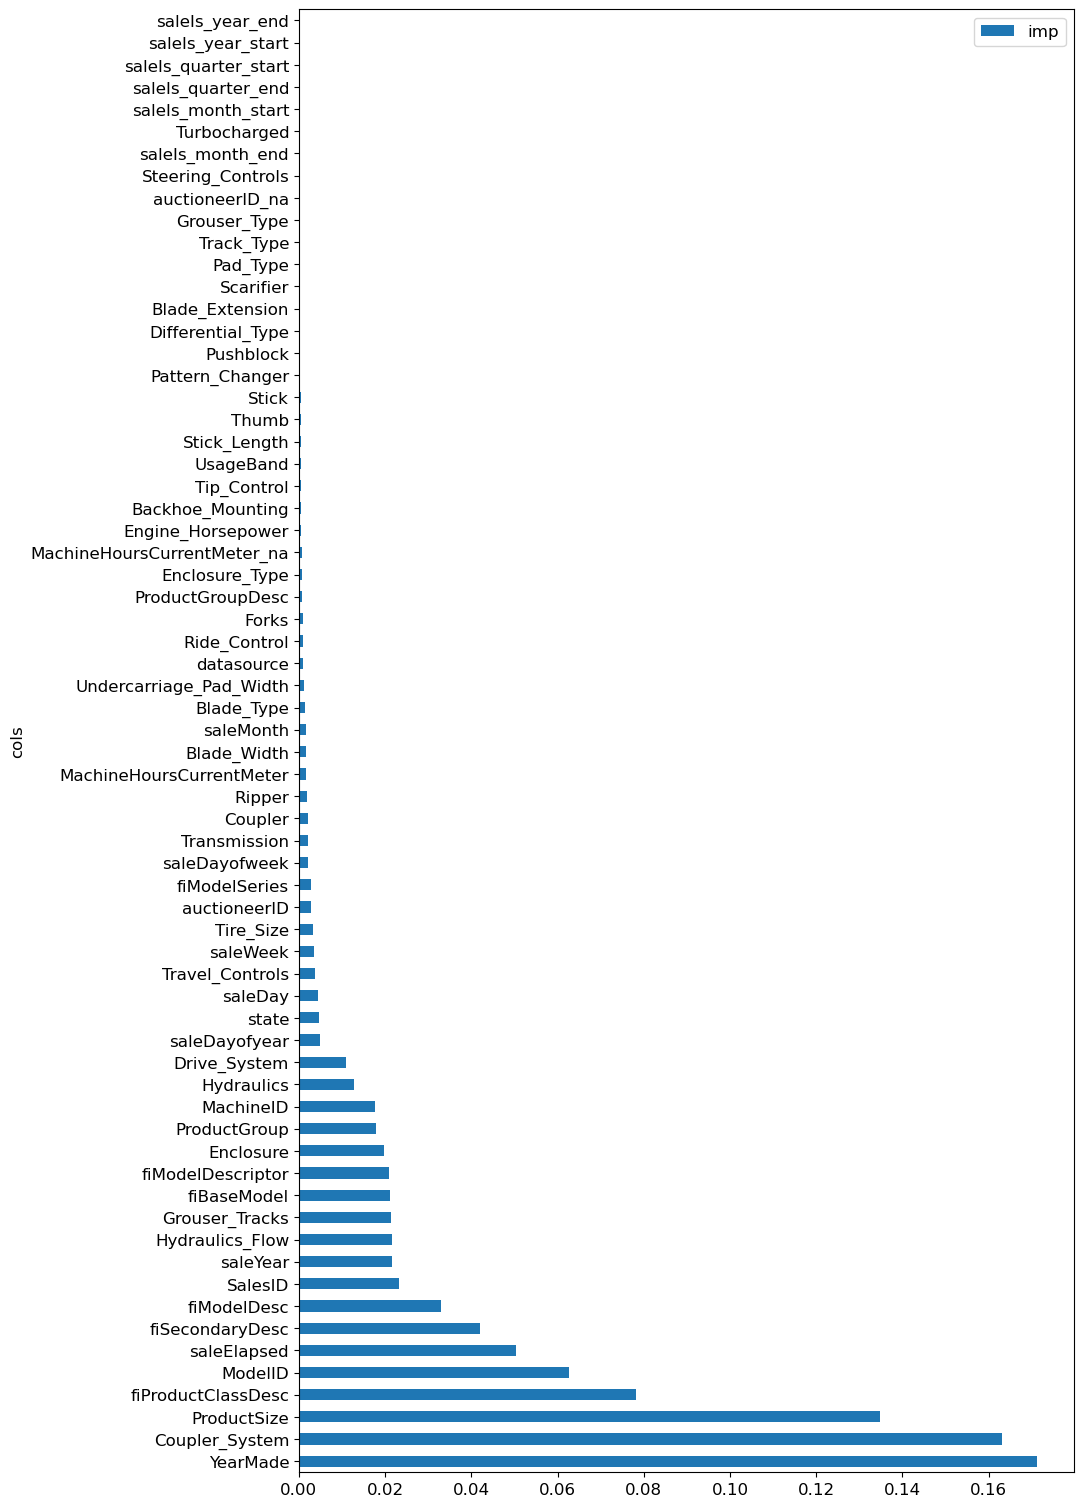

In [80]:
rf_feat_importance(rf,xs).plot('cols','imp','barh',figsize=(10,19))

In [84]:
fi  = rf_feat_importance(rf,xs)
var_keep = fi[fi.imp>=0.005].cols
xs_keep = xs[var_keep]
valid_keep = valid_xs[var_keep]

In [86]:
rf = RandomForestRegressor(max_features=0.5,n_estimators = 10,oob_score=True,max_samples=200_000,min_samples_leaf=5,n_jobs=-1).fit(xs_keep,y)
m_rmse(rf,xs_keep,y),m_rmse(rf,valid_keep,valid_y)

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


(0.186587, 0.235442)

## variable reduction process

### similar columns

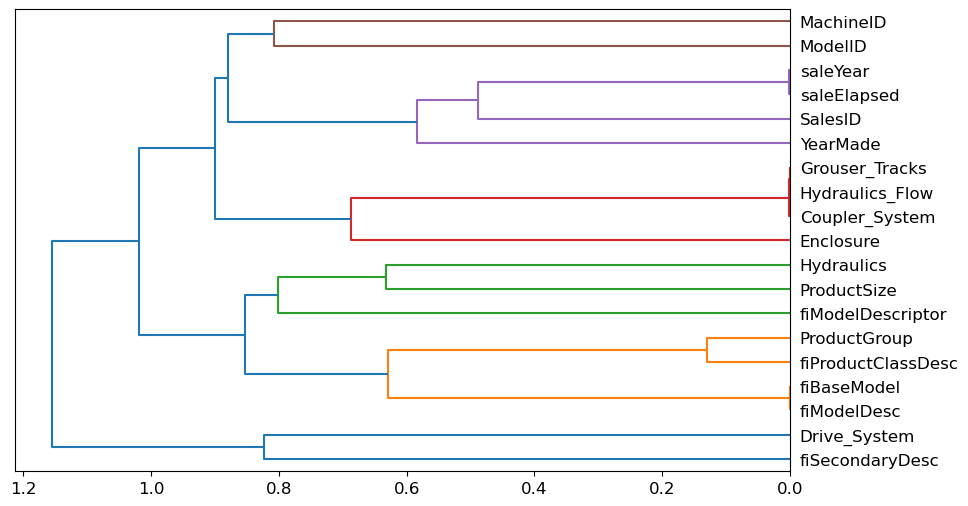

In [87]:
cluster_columns(xs_keep)

In [97]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
xs_cluster = xs_keep.drop(columns=to_drop)
valid_cluster = valid_keep.drop(columns=to_drop)
rf = RandomForestRegressor(max_features=0.5,n_estimators = 10,oob_score=True,max_samples=200_000,min_samples_leaf=5,n_jobs=-1).fit(xs_cluster,y)
m_rmse(rf,xs_cluster,y),m_rmse(rf,valid_cluster,valid_y)

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


(0.18808, 0.238067)

### column values creating issue (data leakage)

In [95]:
import sklearn
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(rf, valid_keep, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/inspection/__init__.py)

## interpreting the predictions on validation set

In [98]:
!pip install treeinterpreter

In [99]:
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3389 sha256=1fa70190ebb3e3c7749acaa6222d0c0e09908ef897f4c5d45de8f7893a4c9289
  Stored in directory: /home/nehaiitr/.cache/pip/wheels/49/9a/ff/ec03fce8e52feb9578e6d919014384cd15a7f1a2d90f56fce9
Successfully built waterfallcharts


In [100]:


#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
     


In [104]:
row = valid_cluster.iloc[:5]
prediction,bias,contribution = treeinterpreter.predict(rf,row.values)

In [108]:
prediction.shape,bias.shape,contribution.shape

((5, 1), (5,), (5, 16))

<module 'matplotlib.pyplot' from '/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

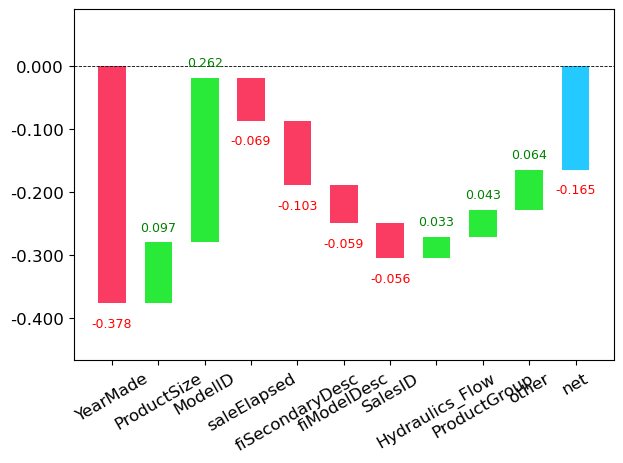

In [111]:
waterfall(valid_cluster.columns,contribution[0],threshold=0.08,formatting='{:,.3f}')

## out of domain data

In [115]:
df_dom = pd.concat([xs_cluster,valid_cluster])
is_valid = [0]*len(xs_cluster) + [1]*len(valid_cluster)

rf_dom = rf_model(df_dom,is_valid)

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


In [120]:
rf_feat_importance(rf_dom,df_dom).head(5)

5     saleElapsed
8         SalesID
4         ModelID
13      MachineID
0        YearMade
Name: cols, dtype: object

In [121]:
m = rf_model(xs_cluster,y)
print(f"original : {m_rmse(m,valid_cluster,valid_y)}")

to_rm = list(rf_feat_importance(rf_dom,df_dom).head(5).cols)

for col in to_rm:
    m = rf_model(xs_cluster.drop(columns=[col]),y)
    print(f"{col} : {m_rmse(m,valid_cluster.drop(columns=[col]),valid_y)}")

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


original : 0.238731


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


saleElapsed : 0.240905


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


SalesID : 0.237365


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


ModelID : 0.241477


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


MachineID : 0.236126
YearMade : 0.270269


/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


In [123]:
time_vars = ['SalesID','MachineID']
xs_time = xs_cluster.drop(columns=time_vars)
valid_time = valid_cluster.drop(columns=time_vars)

m = rf_model(xs_time,y)
m_rmse(m,xs_time,y),m_rmse(m,valid_time,valid_y)

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


(0.195094, 0.235476)

# Neural Network

In [126]:
df_nn = pd.read_csv(path/'TrainAndValid.csv',low_memory=False)
sizes = 'Large', 'Large / Medium', 'Medium','Small', 'Mini','Compact'
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'] = df_nn['ProductSize'].cat.set_categories(sizes,ordered =True)
depVar = 'SalePrice'
df_nn[depVar] = np.log(df_nn.SalePrice)
df_nn = add_datepart(df_nn,'saledate')

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [131]:
df_nn_final = df_nn[list(xs_time.columns) + [depVar]]
cont,cat = cont_cat_split(df_nn_final,max_card=9000,dep_var=depVar)

In [132]:
cont

['saleElapsed']

In [135]:
df_nn_final[cat].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Hydraulics_Flow          3
fiModelDescriptor      140
Enclosure                6
ProductGroup             6
Hydraulics              12
Drive_System             4
dtype: int64

In [136]:
big_col = ['fiModelDesc']
m1 = rf_model(xs_time.drop(columns=big_col,axis=1),y)
m_rmse(m1,xs_time.drop(columns=big_col,axis=1),y),m_rmse(m1,valid_time.drop(columns=big_col,axis=1),valid_y)

/home/nehaiitr/mambaforge/envs/jlabenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


(0.199982, 0.23647)

In [137]:
cat.remove(big_col[0])

In [140]:
procs_nn = [Categorify,FillMissing,Normalize]
to_nn = TabularPandas(df_nn_final,procs = procs_nn,cat_names=cat,cont_names=cont,y_names=depVar,splits=splits)
dls = to_nn.dataloaders(1024)

In [142]:
max(to_nn.train.y),min(to_nn.train.y)

(11.863582611083984, 8.465899467468262)

In [144]:
learn = tabular_learner(dls,layers = [500,250],y_range= (8,12),n_out=1,loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

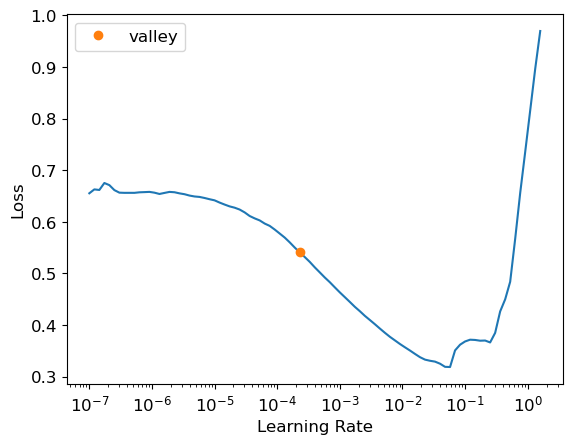

In [145]:
learn.lr_find()

In [147]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062467,0.061261,00:08
1,0.053708,0.054813,00:08
2,0.047534,0.055354,00:06
3,0.043534,0.050626,00:06
4,0.040521,0.049551,00:06


In [148]:
preds,target = learn.get_preds()
r_rmse(preds,target)

0.222601

In [149]:
preds.shape

torch.Size([7988, 1])

In [151]:
learn.save("nn")

Path('models/nn.pth')

# Ensembling

In [154]:
rf_preds = m.predict(valid_time)
ens_preds = (to_np(preds.squeeze(1))+rf_preds)/2

In [155]:
r_rmse(ens_preds,valid_y)

0.222462